In [1]:
!pip -q install plotly ipywidgets openpyxl
import ipywidgets as widgets
from IPython.display import display


In [2]:
import pandas as pd

# Si el xlsx está en la misma carpeta del cuaderno:
FILE = "LLMs cronología.xlsx"

raw = pd.read_excel(FILE)

# La primera fila contiene los nombres de columna reales
raw_header = raw.iloc[0]
df = raw[1:].copy()
df.columns = raw_header

# Columnas clave
COL_MODEL = "Model"
COL_PARAMS = "Parameters \n(B)"
COL_DATE = "Announced\n▼"

# Benchmarks (si no existen algunos, no pasa nada; lo manejaremos)
BENCH_COLS = [c for c in ["MMLU", "MMLU\n-Pro", "GPQA", "HLE", "ALScore \n\"ALScore\" is a quick and dirty rating of the model's power. The formula is:\nSqr Root of (Parameters x Tokens) ÷ 300.\nAny ALScore ≥ 1.0 is a powerful model in mid-2023."] if c in df.columns]

# Limpieza básica
df = df[[COL_MODEL, COL_PARAMS, COL_DATE] + BENCH_COLS].copy()

df[COL_PARAMS] = pd.to_numeric(df[COL_PARAMS], errors="coerce")
df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors="coerce")

# Filtra filas sin fecha o sin params
df = df.dropna(subset=[COL_MODEL, COL_PARAMS, COL_DATE])

# Mantener desde 2023 (como ya estabas haciendo)
df = df[df[COL_DATE].dt.year >= 2023].copy()

# Benchmarks a numérico
for c in BENCH_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df.head(), df.shape, BENCH_COLS


C:\Users\Jontanon\AppData\Local\Temp\ipykernel_9952\2177711143.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors="coerce")


(0               Model  Parameters \n(B) Announced\n▼  MMLU  MMLU\n-Pro  GPQA  \
 8      Step 3.5 Flash             196.0   2026-02-01   NaN         NaN   NaN   
 9   Assistant_Pepe_8B               8.0   2026-01-01   NaN         NaN   NaN   
 10               SERA              32.0   2026-01-01   NaN         NaN   NaN   
 11          Kimi K2.5            1000.0   2026-01-01   NaN        87.1  87.6   
 12      GLM-4.7-Flash              30.0   2026-01-01   NaN         NaN  75.2   
 
 0    HLE  \
 8    NaN   
 9    NaN   
 10   NaN   
 11  50.2   
 12  14.4   
 
 0   ALScore \n"ALScore" is a quick and dirty rating of the model's power. The formula is:\nSqr Root of (Parameters x Tokens) ÷ 300.\nAny ALScore ≥ 1.0 is a powerful model in mid-2023.  
 8                                            6.260990                                                                                                                                    
 9                                            1.177568    

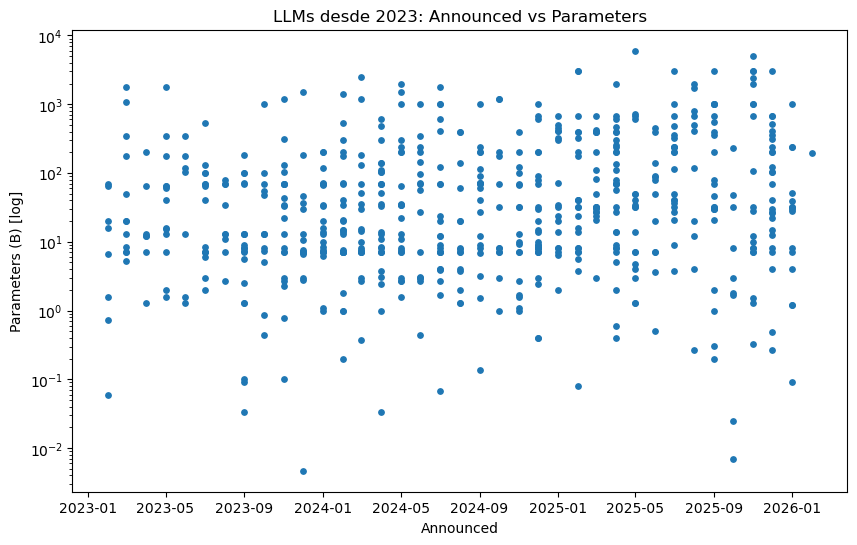

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(df[COL_DATE], df[COL_PARAMS], s=15)
plt.yscale("log")
plt.xlabel("Announced")
plt.ylabel("Parameters (B) [log]")
plt.title("LLMs desde 2023: Announced vs Parameters")
plt.show()


In [10]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# Si no hay benchmarks numéricos, avisamos
if len(BENCH_COLS) == 0:
    print("No se detectaron columnas de benchmarks en el Excel (MMLU/GPQA/HLE/etc).")
else:
    # --- RANGOS BASE PARA SLIDERS ---
    min_date = df[COL_DATE].min()
    max_date = df[COL_DATE].max()

    min_p = float(df[COL_PARAMS].min())
    max_p = float(df[COL_PARAMS].max())

    # --- WIDGETS ---
    bench_dd = widgets.Dropdown(
        options=BENCH_COLS,
        value=BENCH_COLS[0],
        description="Benchmark:",
        layout=widgets.Layout(width="520px")
    )

    ymode = widgets.ToggleButtons(
        options=[("Tamaño (params)", "params"), ("Score (benchmark)", "bench")],
        value="params",
        description="Eje Y:",
        layout=widgets.Layout(width="520px")
    )

    only_with_score = widgets.Checkbox(
        value=True,
        description="Solo modelos con score (no NaN)"
    )

    topn = widgets.IntSlider(
        value=20, min=5, max=100, step=5,
        description="Top N:",
        continuous_update=False
    )

    # Número total de modelos visibles (además del topN, que se resaltará)
    show_n = widgets.IntSlider(
        value=300, min=50, max=min(2000, len(df)), step=50,
        description="Mostrar N:",
        continuous_update=False
    )

    # Rango de fechas
    df_dates = df.dropna(subset=[COL_DATE]).copy()
    df_dates[COL_DATE] = pd.to_datetime(df_dates[COL_DATE], errors="coerce")
    df_dates = df_dates.dropna(subset=[COL_DATE])
    
    min_date = df_dates[COL_DATE].min()
    max_date = df_dates[COL_DATE].max()
    
    # Opciones: una lista diaria entre min y max (si el rango es enorme, lo podemos cambiar a mensual)
    date_options = pd.date_range(min_date.normalize(), max_date.normalize(), freq="D").to_pydatetime().tolist()
    
    #  value debe ser (start, end), no index
    date_range = widgets.SelectionRangeSlider(
        options=date_options,
        value=(date_options[0], date_options[-1]),
        description="Fechas:",
        layout=widgets.Layout(width="860px"),
        continuous_update=False
    )

    # Rango de parámetros
    params_range = widgets.FloatRangeSlider(
        value=[min_p, max_p],
        min=min_p,
        max=max_p,
        step=max((max_p - min_p) / 200, 0.01),
        description="Params (B):",
        readout_format=".2f",
        layout=widgets.Layout(width="860px"),
        continuous_update=False
    )

    # Tamaño de figura (muy grande)
    height = widgets.IntSlider(value=850, min=500, max=1200, step=50, description="Alto(px):", continuous_update=False)
    width  = widgets.IntSlider(value=1600, min=900, max=2200, step=50, description="Ancho(px):", continuous_update=False)

    # --- FUNCIÓN PRINCIPAL ---
    def plot_dynamic(
        benchmark,
        y_mode,
        top_n,
        show_n_models,
        only_score,
        date_sel,
        p_sel,
        fig_h,
        fig_w
    ):
        d = df.copy()

        # Aplicar filtros de fecha
        start_date, end_date = pd.to_datetime(date_sel[0]), pd.to_datetime(date_sel[1])
        d = d[(d[COL_DATE] >= start_date) & (d[COL_DATE] <= end_date)]

        # Aplicar filtros de parámetros
        pmin, pmax = p_sel
        d = d[(d[COL_PARAMS] >= pmin) & (d[COL_PARAMS] <= pmax)]

        # Solo con score (si se pide)
        if only_score:
            d = d.dropna(subset=[benchmark])

        # Si tras filtrar no hay datos
        if len(d) == 0:
            print("No hay modelos con los filtros actuales.")
            return

        # Determinar eje Y
        if y_mode == "params":
            ycol = COL_PARAMS
            ytitle = "Parameters (B) [log]"
            logy = True
        else:
            ycol = benchmark
            ytitle = benchmark
            logy = False

        # --- Selección de TopN por benchmark (en el conjunto filtrado) ---
        d_top = d.dropna(subset=[benchmark]).nlargest(top_n, benchmark).copy()

        # --- Selección de modelos a mostrar (para no saturar) ---
        # Prioridad: incluir siempre el TopN y completar hasta show_n_models
        # Estrategia: ordenamos por fecha (para visión temporal), y tomamos una muestra equiespaciada si hace falta.
        d_sorted = d.sort_values(COL_DATE).copy()

        if len(d_sorted) > show_n_models:
            idx = np.linspace(0, len(d_sorted) - 1, show_n_models).astype(int)
            d_show = d_sorted.iloc[idx].copy()
        else:
            d_show = d_sorted

        # Asegurar que el TopN esté incluido en d_show
        if len(d_top) > 0:
            d_show = pd.concat([d_show, d_top]).drop_duplicates(subset=[COL_MODEL, COL_DATE])

        # --- Gráfico base ---
        fig = px.scatter(
            d_show,
            x=COL_DATE,
            y=ycol,
            hover_name=COL_MODEL,
            hover_data={
                COL_PARAMS: True,
                benchmark: True,
                COL_DATE: True
            },
            opacity=0.25,
            log_y=logy,
            title=f"Temporal (X) + filtros | Top {top_n} por {benchmark} | Mostrando ~{len(d_show)} modelos"
        )

        # --- Resaltar TopN (rojo + etiquetas con nombre y fecha) ---
        if len(d_top) > 0:
            labels = [
                f"{row[COL_MODEL]} ({row[COL_DATE].strftime('%Y-%m-%d')})"
                for _, row in d_top.sort_values(COL_DATE).iterrows()
            ]

            fig.add_trace(go.Scatter(
                x=d_top[COL_DATE],
                y=d_top[ycol],
                mode="markers+text",
                text=labels,
                textposition="top center",
                name=f"Top {top_n} {benchmark}",
            ))

        # --- Layout GRANDE + slider de rango visible en X ---
        fig.update_layout(
            width=fig_w,
            height=fig_h,
            xaxis_title="Announced",
            yaxis_title=ytitle,
            margin=dict(l=60, r=30, t=70, b=60),
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0.01)
        )

        fig.show()
        fig.write_html(
    "llms_timeline_interactive.html",
    include_plotlyjs="cdn",   # más ligero
    full_html=True
)

    # --- UI ---
    row1 = widgets.HBox([bench_dd, ymode, only_with_score])
    row2 = widgets.HBox([topn, show_n, height, width])
    ui = widgets.VBox([row1, row2, date_range, params_range])

    out = widgets.interactive_output(
        plot_dynamic,
        {
            "benchmark": bench_dd,
            "y_mode": ymode,
            "top_n": topn,
            "show_n_models": show_n,
            "only_score": only_with_score,
            "date_sel": date_range,
            "p_sel": params_range,
            "fig_h": height,
            "fig_w": width,
        }
    )

    display(ui, out)



Output()

In [5]:
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# Si no hay benchmarks numéricos, avisamos
if len(BENCH_COLS) == 0:
    print("No se detectaron columnas de benchmarks en el Excel (MMLU/GPQA/HLE/etc).")
else:
    bench_dd = widgets.Dropdown(
        options=BENCH_COLS,
        value=BENCH_COLS[0],
        description="Benchmark:",
        layout=widgets.Layout(width="600px")
    )

    ymode = widgets.ToggleButtons(
        options=[("Tamaño (params)", "params"), ("Score (benchmark)", "bench")],
        value="params",
        description="Eje Y:",
    )

    topn = widgets.IntSlider(
        value=20, min=5, max=100, step=5,
        description="Top N:",
        continuous_update=False
    )

    only_public = widgets.Checkbox(
        value=False,
        description="Solo filas con score (no NaN)"
    )

    def plot_top_benchmark(benchmark, y_mode, top_n, only_with_score):
        d = df.copy()

        # Solo modelos con score disponible (si se pide)
        if only_with_score:
            d = d.dropna(subset=[benchmark])

        # Selección top-N por benchmark
        d_top = d.dropna(subset=[benchmark]).nlargest(top_n, benchmark).copy()

        # Eje Y: params o benchmark
        if y_mode == "params":
            ycol = COL_PARAMS
            ytitle = "Parameters (B) [log]"
            logy = True
        else:
            ycol = benchmark
            ytitle = benchmark
            logy = False

        fig = px.scatter(
            d, x=COL_DATE, y=ycol,
            hover_name=COL_MODEL,
            opacity=0.25,
            log_y=logy,
            title=f"Temporal (X) + filtro: Top {top_n} por {benchmark}"
        )

        # Puntos top-N destacados
        fig.add_trace(go.Scatter(
            x=d_top[COL_DATE],
            y=d_top[ycol],
            mode="markers+text",
            text=[f"{m}" for m in d_top[COL_MODEL]],
            textposition="top center",
            name=f"Top {top_n} {benchmark}",
        ))

        # Etiqueta con fecha en hover
        fig.update_traces(
            hovertemplate="<b>%{hovertext}</b><br>Announced=%{x}<br>Y=%{y}<extra></extra>"
        )

        fig.update_layout(
            xaxis_title="Announced",
            yaxis_title=ytitle
        )
        fig.show()

    ui = widgets.VBox([bench_dd, ymode, topn, only_public])
    out = widgets.interactive_output(
        plot_top_benchmark,
        {"benchmark": bench_dd, "y_mode": ymode, "top_n": topn, "only_with_score": only_public}
    )

    display(ui, out)


Output()

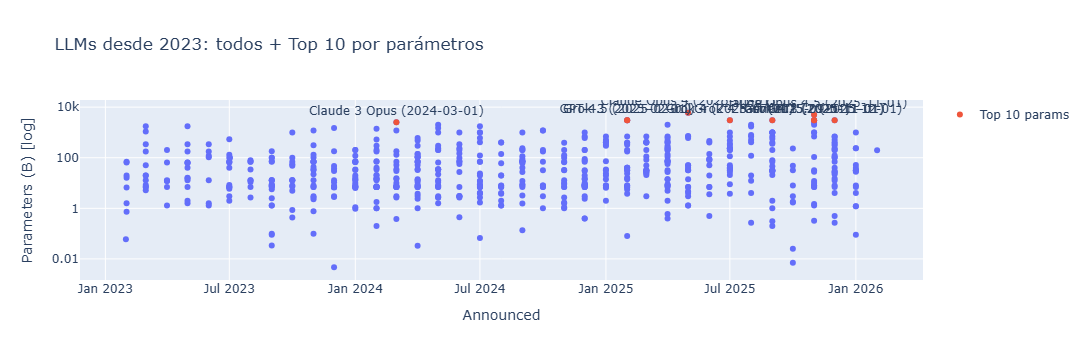

In [6]:
import plotly.express as px
import plotly.graph_objects as go

TOP = 10
d_all = df.copy()
d_top = d_all.nlargest(TOP, COL_PARAMS).copy()

fig = px.scatter(
    d_all, x=COL_DATE, y=COL_PARAMS,
    hover_name=COL_MODEL, log_y=True,
    title=f"LLMs desde 2023: todos + Top {TOP} por parámetros"
)

# Top resaltado + etiqueta con fecha
labels = [
    f"{row[COL_MODEL]} ({row[COL_DATE].strftime('%Y-%m-%d')})"
    for _, row in d_top.iterrows()
]

fig.add_trace(go.Scatter(
    x=d_top[COL_DATE],
    y=d_top[COL_PARAMS],
    mode="markers+text",
    text=labels,
    textposition="top center",
    name=f"Top {TOP} params",
))

fig.update_layout(xaxis_title="Announced", yaxis_title="Parameters (B) [log]")
fig.show()


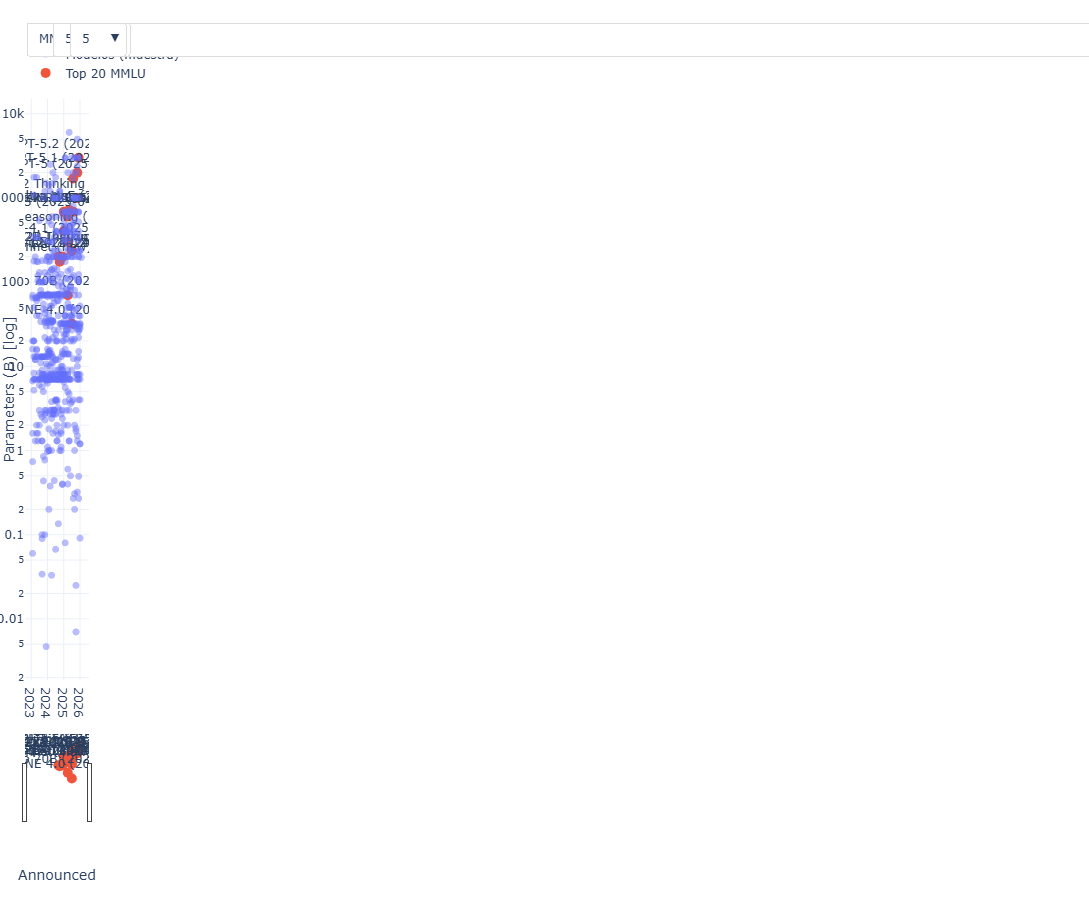

In [11]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def build_browser_dashboard(df, bench_cols, out_html="llms_dashboard.html"):
    # --- preparar columnas y limpiar ---
    d = df.copy()
    d = d.dropna(subset=[COL_DATE, COL_PARAMS, COL_MODEL])
    d[COL_DATE] = pd.to_datetime(d[COL_DATE], errors="coerce")
    d[COL_PARAMS] = pd.to_numeric(d[COL_PARAMS], errors="coerce")
    d = d.dropna(subset=[COL_DATE, COL_PARAMS])
    d = d.sort_values(COL_DATE)

    # benchmarks a numérico
    for b in bench_cols:
        d[b] = pd.to_numeric(d[b], errors="coerce")

    # --- presets de "cuántos modelos mostrar" (muestreo temporal) ---
    presets = [50, 100, 200, 500]
    presets = [p for p in presets if p < len(d)]
    presets.append(len(d))  # "Todos"

    sampled = {}
    for p in presets:
        if p == len(d):
            sampled[p] = d.copy()
        else:
            idx = np.linspace(0, len(d)-1, p).astype(int)
            sampled[p] = d.iloc[idx].copy()

    # --- slider de parámetros (en escala log, más natural) ---
    pmin = float(d[COL_PARAMS].min())
    pmax = float(d[COL_PARAMS].max())
    logpmin = np.log10(max(pmin, 1e-6))
    logpmax = np.log10(max(pmax, 1e-6))

    # --- figura ---
    fig = go.Figure()

    # Usaremos un “estado” inicial
    init_bench = bench_cols[0]
    init_showN = presets[-1]  # todos
    init_topN = 20

    # Base: puntos (todos los modelos del preset inicial)
    base = sampled[init_showN].copy()

    fig.add_trace(go.Scattergl(
        x=base[COL_DATE],
        y=base[COL_PARAMS],
        mode="markers",
        name="Modelos (muestra)",
        text=base[COL_MODEL],
        customdata=np.stack([
            base[COL_PARAMS].to_numpy(),
            base[init_bench].to_numpy()
        ], axis=1),
        hovertemplate=(
            "<b>%{text}</b><br>"
            "Announced=%{x|%Y-%m-%d}<br>"
            "Params(B)=%{customdata[0]:.3g}<br>"
            f"{init_bench}=%{{customdata[1]:.3g}}<extra></extra>"
        ),
        marker=dict(size=7, opacity=0.45),
    ))

    # TopN (por benchmark) resaltado
    top = base.dropna(subset=[init_bench]).nlargest(init_topN, init_bench).copy()
    fig.add_trace(go.Scatter(
        x=top[COL_DATE],
        y=top[COL_PARAMS],
        mode="markers+text",
        name=f"Top {init_topN} {init_bench}",
        text=[f"{m} ({dt:%Y-%m-%d})" for m, dt in zip(top[COL_MODEL], top[COL_DATE])],
        textposition="top center",
        marker=dict(size=10),
        hovertemplate="<b>%{text}</b><br>Announced=%{x|%Y-%m-%d}<br>Params(B)=%{y:.3g}<extra></extra>"
    ))

    # --- layout atractivo + temporal ---
    fig.update_layout(
        title="LLMs Timeline Dashboard (exportable a navegador)",
        template="plotly_white",
        width=1700,
        height=900,
        margin=dict(l=70, r=40, t=80, b=70),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0.01),
    )

    # Eje X temporal + range slider
    fig.update_xaxes(
        title="Announced",
        rangeslider=dict(visible=True),
        showgrid=True
    )

    # Eje Y log
    fig.update_yaxes(
        title="Parameters (B) [log]",
        type="log",
        showgrid=True
    )

    # --- CONTROLES NATIVOS (en el propio HTML) ---
    # 1) Dropdown: benchmark
    # 2) Dropdown: mostrar N (presets)
    # 3) Dropdown: TopN
    # 4) Slider: filtro params (log-range) -> se aplica con relayout (range de y)

    # helper para construir arrays para cada preset+benchmark+topN (sin JS externo)
    topN_options = [5, 10, 20, 50]
    topN_options = [t for t in topN_options if t <= 100]

    # Precalculamos combinaciones en diccionarios para actualizar trazas
    # Trace0 = base, Trace1 = top
    cache = {}
    for showN in presets:
        for bench in bench_cols:
            dd = sampled[showN].copy()
            cache[(showN, bench, "base")] = dict(
                x=dd[COL_DATE].to_list(),
                y=dd[COL_PARAMS].to_list(),
                text=dd[COL_MODEL].to_list(),
                customdata=np.stack([dd[COL_PARAMS].to_numpy(), dd[bench].to_numpy()], axis=1).tolist(),
                hovertemplate=(
                    "<b>%{text}</b><br>"
                    "Announced=%{x|%Y-%m-%d}<br>"
                    "Params(B)=%{customdata[0]:.3g}<br>"
                    f"{bench}=%{{customdata[1]:.3g}}<extra></extra>"
                )
            )
            for tN in topN_options:
                tt = dd.dropna(subset=[bench]).nlargest(tN, bench).copy()
                cache[(showN, bench, tN)] = dict(
                    x=tt[COL_DATE].to_list(),
                    y=tt[COL_PARAMS].to_list(),
                    text=[f"{m} ({dt:%Y-%m-%d})" for m, dt in zip(tt[COL_MODEL], tt[COL_DATE])],
                    name=f"Top {tN} {bench}"
                )

    # Dropdown BENCHMARK
    bench_buttons = []
    for bench in bench_cols:
        bench_buttons.append(dict(
            label=bench.replace("\n", " "),
            method="update",
            args=[
                {
                    "x": [cache[(init_showN, bench, "base")]["x"], cache[(init_showN, bench, init_topN)]["x"]],
                    "y": [cache[(init_showN, bench, "base")]["y"], cache[(init_showN, bench, init_topN)]["y"]],
                    "text": [cache[(init_showN, bench, "base")]["text"], cache[(init_showN, bench, init_topN)]["text"]],
                    "customdata": [cache[(init_showN, bench, "base")]["customdata"], None],
                    "hovertemplate": [cache[(init_showN, bench, "base")]["hovertemplate"], fig.data[1].hovertemplate],
                    "name": ["Modelos (muestra)", cache[(init_showN, bench, init_topN)]["name"]],
                }
            ]
        ))

    # Dropdown MOSTRAR N
    show_buttons = []
    for showN in presets:
        label = f"{showN}" if showN != len(d) else "Todos"
        show_buttons.append(dict(
            label=label,
            method="update",
            args=[
                {
                    "x": [cache[(showN, init_bench, "base")]["x"], cache[(showN, init_bench, init_topN)]["x"]],
                    "y": [cache[(showN, init_bench, "base")]["y"], cache[(showN, init_bench, init_topN)]["y"]],
                    "text": [cache[(showN, init_bench, "base")]["text"], cache[(showN, init_bench, init_topN)]["text"]],
                    "customdata": [cache[(showN, init_bench, "base")]["customdata"], None],
                    "hovertemplate": [cache[(showN, init_bench, "base")]["hovertemplate"], fig.data[1].hovertemplate],
                    "name": ["Modelos (muestra)", cache[(showN, init_bench, init_topN)]["name"]],
                }
            ]
        ))

    # Dropdown TOPN
    top_buttons = []
    for tN in topN_options:
        top_buttons.append(dict(
            label=str(tN),
            method="update",
            args=[
                {
                    "x": [cache[(init_showN, init_bench, "base")]["x"], cache[(init_showN, init_bench, tN)]["x"]],
                    "y": [cache[(init_showN, init_bench, "base")]["y"], cache[(init_showN, init_bench, tN)]["y"]],
                    "text": [cache[(init_showN, init_bench, "base")]["text"], cache[(init_showN, init_bench, tN)]["text"]],
                    "name": ["Modelos (muestra)", cache[(init_showN, init_bench, tN)]["name"]],
                }
            ]
        ))

    fig.update_layout(
        updatemenus=[
            dict(
                type="dropdown",
                x=0.01, y=1.15,
                xanchor="left", yanchor="top",
                buttons=bench_buttons,
                showactive=True,
                bgcolor="white",
                bordercolor="#ddd",
                borderwidth=1,
                pad={"r": 10, "t": 10},
                font={"size": 12},
            ),
            dict(
                type="dropdown",
                x=0.42, y=1.15,
                xanchor="left", yanchor="top",
                buttons=show_buttons,
                showactive=True,
                bgcolor="white",
                bordercolor="#ddd",
                borderwidth=1,
                pad={"r": 10, "t": 10},
                font={"size": 12},
            ),
            dict(
                type="dropdown",
                x=0.68, y=1.15,
                xanchor="left", yanchor="top",
                buttons=top_buttons,
                showactive=True,
                bgcolor="white",
                bordercolor="#ddd",
                borderwidth=1,
                pad={"r": 10, "t": 10},
                font={"size": 12},
            ),
        ],
        annotations=[
            dict(text="Benchmark", x=0.01, y=1.20, xref="paper", yref="paper", showarrow=False),
            dict(text="Mostrar N", x=0.42, y=1.20, xref="paper", yref="paper", showarrow=False),
            dict(text="Top N", x=0.68, y=1.20, xref="paper", yref="paper", showarrow=False),
            dict(
                text="Tip: usa el range slider inferior para filtrar por fechas",
                x=0.99, y=1.20, xref="paper", yref="paper", showarrow=False, xanchor="right"
            )
        ]
    )

    # Guardar HTML (navegador)
    fig.write_html(out_html, include_plotlyjs=True, full_html=True)
    return fig

fig = build_browser_dashboard(df, BENCH_COLS, out_html="llms_dashboard.html")
fig.show()
